In [1]:
import argparse
import json
import os

import numpy as np
import pytorch_lightning as L
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from transformers import (
    ConditionalDetrConfig,
    ConditionalDetrForObjectDetection,
    ConditionalDetrForSegmentation,
    DeformableDetrConfig,
    DeformableDetrForObjectDetection,
    DetrConfig,
    DetrForObjectDetection,
    DetrForSegmentation,
    DetrImageProcessor,
)

import modules
import utils  
import importlib 
importlib.reload(utils)
importlib.reload(modules)

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'modules' from '/home/feity/cryoem/modules.py'>

In [21]:
for i in os.listdir("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"):
    if i.endswith(".mrc"):
        data = utils.readTomogram("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i)
    else:
        continue
    name = i.split(".")[0]
    if not os.path.exists("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+name):
        os.mkdir("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+name) 
    l, h, w = data.shape
    for j in range(0, l, 5):
        res = np.zeros((3, h, w))
        res[1] = data[j] 
        res[0] = np.mean(data[max(0, j-10):max(j, 1)], axis=0)
        res[2] = np.mean(data[j:j+10], axis=0)
        for k in range(3):
            res[k] -= np.min(res[k])
            res[k] /= np.max(res[k])
        np.save("%s/minmax_%i.npy"%("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+name, j), res)

## construct stage 2 dataset

In [7]:
i="sllt0039_9.pkl"
model = utils.loadModel("/data/transformer_project/transforemer_model/train_data/training/results/conditional_detr/fold1_Unet7", "epoch=107-total_validate_loss=0.5987.ckpt")
model = model.eval() 
# dataset = modules.TestDataset("/data/transformer_project/transforemer_model/train_data/training/data/sllt0039_9_5")
dataset = modules.CocoDetection(
"/data/transformer_project/transforemer_model/train_data/training/data/", 
"/data/transformer_project/transforemer_model/train_data/training/data/annotations/"+i,
                            is_npy=True, filter_class=[3, 4, 7, 12, 14], map_class={"3":0, "4":1, "7":2, "12":3, "14":4}, require_mask=True, transform=utils.getConstantTransform(), add_classname=True, norm="hist",filtermin=5
)
retdict = utils.buildStage2(model, dataset, (800, 800), 0.05, has_none=False, empty=5)
d = utils.convertStage2Dataset(retdict)
torch.save(d, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold1_"+i.split(".")[0]+"_stage2dataset_stage12_609.pkl")
torch.save(retdict, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold1_"+i.split(".")[0]+"_stage2dict_stage12_609.pkl")
# model.stage = "stage 1"

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model at stage  stage 1 + 2 + 3


/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/feity/cryoem/utils.py:532: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded v

incompatible parameters ['model.class_labels_classifier.weight', 'model.class_labels_classifier.bias', 'additional_input_layer.layer1.weight', 'additional_input_layer.layer1.bias', 'additional_input_layer.layer2.weight', 'additional_input_layer.layer2.bias', 'gnn.conv1.lin_l.weight', 'gnn.conv1.lin_l.bias', 'gnn.conv1.lin_r.weight', 'gnn.conv2.lin_l.weight', 'gnn.conv2.lin_l.bias', 'gnn.conv2.lin_r.weight', 'gnn.conv3.lin_l.weight', 'gnn.conv3.lin_l.bias', 'gnn.conv3.lin_r.weight', 'gnn.cls_head.0.weight', 'gnn.cls_head.0.bias', 'gnn.cls_head.2.weight', 'gnn.cls_head.2.bias', 'gnn.box_head.0.weight', 'gnn.box_head.0.bias', 'gnn.box_head.2.weight', 'gnn.box_head.2.bias', 'gnn.edge_head.0.weight', 'gnn.edge_head.0.bias', 'gnn.edge_head.2.weight', 'gnn.edge_head.2.bias', 'gnn.edge_head.4.weight', 'cri.weight', 'mask_head.inc.double_conv.0.weight', 'mask_head.inc.double_conv.1.weight', 'mask_head.inc.double_conv.1.bias', 'mask_head.inc.double_conv.3.weight', 'mask_head.inc.double_conv.4.we

/home/feity/cryoem/utils.py:1226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, checkpoint), map_location="cpu")["state_dict"]


incompatible parameters []
finish loading parameters
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
slice 0
check whether reserve  tensor(178) tensor(178)
torch.Size([178]) torch.Size([178, 4])
obj_cnts: 178
slice 1
check whether reserve  tensor(220) tensor(220)
torch.Size([220]) torch.Size([220, 4])
obj_cnts: 398
slice 2
check whether reserve  tensor(207) tensor(207)
torch.Size([207]) torch.Size([207, 4])
obj_cnts: 605
slice 3
check whether reserve  tensor(211) tensor(211)
torch.Size([211]) torch.Size([211, 4])
obj_cnts: 816
slice 4
check whether reserve  tensor(207) tensor(207)
torch.Size([207]) torch.Size([207, 4])
obj_cnts: 1023
slice 5
check whether reserve  tensor(220) tensor(220)
torch.Size([220]) torch.Size([220, 4])
obj_cnts: 1243
slice 6
check whether reserve  tensor(218) tensor(218)
torch.Size([218]) torch.Size([218, 4])
obj_cnts: 1461
slice 7
check whether reserve  tensor(216) tensor(217)
torch.Size([217]) torch.Size([217, 4])
obj_cnts: 1

In [ ]:
for i in os.listdir("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"):
    # dataset = modules.CocoDetection(
    #     "/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/", 
    #     "/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i,
    #     is_npy=True, filter_class=[3, 4, 7, 12, 14], map_class={"3":0, "4":1, "7":2, "12":3, "14":4}, require_mask=True, transform=utils.getConstantTransform(), add_classname=True, norm="hist",filtermin=5
    # )
    if i.endswith(".mrc"):
        continue
    if not os.path.isdir("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i):
        continue
    dataset = modules.TestDataset("/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i)
    retdict = utils.buildStage2(model, dataset, (800, 800), 0.15, has_none=False, empty=5)
    d = utils.convertStage2Dataset(retdict)
    torch.save(d, "/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i.split(".")[0]+"_stage2dataset_stage12_515.pkl")
    torch.save(retdict, "/data/transformer_project/transforemer_model/test_data/dxd20240920/tomo/"+i.split(".")[0]+"_stage2dict_stage12_515.pkl")

In [3]:
importlib.reload(utils)
importlib.reload(modules)
model = utils.loadModel("/data/transformer_project/transforemer_model/train_data/training/results/conditional_detr/whole_Unet7", "epoch=119-total_validate_loss=0.4131-v1.ckpt")
model.stage = "stage 1"
for j in [42, 43, 44, 45, -1]:
    for i in ["TS_005.pkl", "TS_023.pkl", "TS_031.pkl", "sllt0039_9.pkl", "sllt0051_9.pkl", "sllt0081_9.pkl"]:
        # dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
        #                         "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/"+i,
        #                         is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, maxsize=800, require_mask=True) 
        if j != -1:
            dataset = modules.CocoDetection(
                                            "/data/transformer_project/transforemer_model/train_data/training/data/", 
                                    "/data/transformer_project/transforemer_model/train_data/training/data/annotations/"+i,
                                    is_npy=True, filter_class=[3, 4, 7, 12, 14], map_class={"3":0, "4":1, "7":2, "12":3, "14":4}, require_mask=True, transform=utils.getDefaultTransform(), add_classname=True, norm="hist",filtermin=5
            )
            retdict = utils.buildStage2(model, dataset, (800, 800), -0.05, has_none=False, empty=5, seed=j)
        else:
            dataset = modules.CocoDetection(
                                            "/data/transformer_project/transforemer_model/train_data/training/data/", 
                                    "/data/transformer_project/transforemer_model/train_data/training/data/annotations/"+i,
                                    is_npy=True, filter_class=[3, 4, 7, 12, 14], map_class={"3":0, "4":1, "7":2, "12":3, "14":4}, require_mask=True, transform=utils.getConstantTransform(), add_classname=True, norm="hist",filtermin=5
            )
            retdict = utils.buildStage2(model, dataset, (800, 800), -0.05, has_none=False, empty=5, seed=None)
        
        d = utils.convertStage2Dataset(retdict)
        torch.save(d, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dataset_stage12_609_whole_%d.pkl"%j)
        torch.save(retdict, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dict_stage12_609_whole_%d.pkl"%j)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/feity/cryoem/u

model at stage  stage 1 + 2 + 3
incompatible parameters ['model.class_labels_classifier.weight', 'model.class_labels_classifier.bias', 'additional_input_layer.layer1.weight', 'additional_input_layer.layer1.bias', 'additional_input_layer.layer2.weight', 'additional_input_layer.layer2.bias', 'gnn.conv1.lin_l.weight', 'gnn.conv1.lin_l.bias', 'gnn.conv1.lin_r.weight', 'gnn.conv2.lin_l.weight', 'gnn.conv2.lin_l.bias', 'gnn.conv2.lin_r.weight', 'gnn.conv3.lin_l.weight', 'gnn.conv3.lin_l.bias', 'gnn.conv3.lin_r.weight', 'gnn.cls_head.0.weight', 'gnn.cls_head.0.bias', 'gnn.cls_head.2.weight', 'gnn.cls_head.2.bias', 'gnn.box_head.0.weight', 'gnn.box_head.0.bias', 'gnn.box_head.2.weight', 'gnn.box_head.2.bias', 'gnn.edge_head.0.weight', 'gnn.edge_head.0.bias', 'gnn.edge_head.2.weight', 'gnn.edge_head.2.bias', 'gnn.edge_head.4.weight', 'cri.weight', 'mask_head.inc.double_conv.0.weight', 'mask_head.inc.double_conv.1.weight', 'mask_head.inc.double_conv.1.bias', 'mask_head.inc.double_conv.3.weight',

/home/feity/cryoem/utils.py:1226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, checkpoint), map_location="cpu")["state_dict"]


incompatible parameters []
finish loading parameters
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
slice 0
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 300
slice 1
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 600
slice 2
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 900
slice 3
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 1200
slice 4
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 1500
slice 5
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 1800
slice 6
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 2100
slice 7
check whether reserve  tensor(300) tensor(300)
torch.Size([300]) torch.Size([300, 4])
obj_cnts: 

In [ ]:
importlib.reload(utils)
importlib.reload(modules)
for i in ["sll_0008_9.pkl", "sllt0053_9.pkl", "sllt0061_9.pkl", "sllt0063_9.pkl", "sllt0068_9.pkl", "sllt0073_9.pkl", "sllt0076_9.pkl", "sllt0078_9.pkl", "sllt0079_9.pkl", "sllt0083_9.pkl", "sllt0084_9.pkl", "sllt0085_9.pkl", "sllt0091_9.pkl", "sllta0030_9.pkl", "sllta0032_9.pkl", "sllta0033_9.pkl", "sllta0034_9.pkl", "sllta0035_9.pkl", "slltb0005_9.pkl", "slltb0006_9.pkl", "slltb0013_9.pkl", "slltb0015_9.pkl", "slltb0018_9.pkl", "slltb0028_9.pkl", "slltb0033_9.pkl", "slltb0036_9.pkl", "slltr0002_9.pkl", "slltr0004_9.pkl", "slltr0008_9.pkl", "slltr0010_9.pkl", "slltr0015_9.pkl", "slltr0016_9.pkl", "slltr0017_9.pkl", "slltr0019_9.pkl", "slltr0020_9.pkl", "slltr0023_9.pkl", "slltr0025_9.pkl", "slltr0033_9.pkl", "slltr0037_9.pkl", "slltr0039_9.pkl", "slltr0050_9.pkl"]:
    # dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
    #                         "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/"+i,
    #                         is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, maxsize=800, require_mask=True) 
    dataset = modules.CocoDetection(
                                    "/data/transformer_project/transforemer_model/pretrain_data/clean_dataset/", 
                            "/data/transformer_project/transforemer_model/pretrain_data/clean_dataset/annotations/"+i,
                            is_npy=True, filter_class=[1, 3], map_class={"3":0, "1":1}, require_mask=True, transform=utils.getConstantTransform(), add_classname=True, norm="hist"
    )
    retdict = utils.buildStage2(model, dataset, (800, 800), -1.0, has_none=False, empty=5)
    d = utils.convertStage2Dataset(retdict)
    torch.save(d, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold4_"+i.split(".")[0]+"_stage2dataset_iou.pkl")
    torch.save(retdict, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold4_"+i.split(".")[0]+"_stage2dict_iou.pkl")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
slice 0
check whether reserve  tensor(95) tensor(98)
torch.Size([98]) torch.Size([98, 4])
obj_cnts: 98
slice 1
check whether reserve  tensor(70) tensor(74)
torch.Size([74]) torch.Size([74, 4])
obj_cnts: 172
slice 2
check whether reserve  tensor(84) tensor(90)
torch.Size([90]) torch.Size([90, 4])
obj_cnts: 262
slice 3
check whether reserve  tensor(107) tensor(113)
torch.Size([113]) torch.Size([113, 4])
obj_cnts: 375
slice 4
check whether reserve  tensor(106) tensor(112)
torch.Size([112]) torch.Size([112, 4])
obj_cnts: 487
slice 5
check whether reserve  tensor(114) tensor(117)
torch.Size([117]) torch.Size([117, 4])
obj_cnts: 604
slice 6
check whether reserve  tensor(136) tensor(139)
torch.Size([139]) torch.Size([139, 4])
obj_cnts: 743
slice 7
check whether reserve  tensor(142) tensor(146)
torch.Size([146]) torch.Size([146, 4])
obj_cnts: 889
slice 8
check whether reserve  tensor(173) tensor(176)
torch.Size(

/home/feity/cryoem/utils.py:800: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t.edge_label = torch.tensor(edge_label, dtype=torch.long)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
slice 0
check whether reserve  tensor(86) tensor(87)
torch.Size([87]) torch.Size([87, 4])
obj_cnts: 87
slice 1
check whether reserve  tensor(120) tensor(121)
torch.Size([121]) torch.Size([121, 4])
obj_cnts: 208
slice 2
check whether reserve  tensor(140) tensor(140)
torch.Size([140]) torch.Size([140, 4])
obj_cnts: 348
slice 3
check whether reserve  tensor(156) tensor(157)
torch.Size([157]) torch.Size([157, 4])
obj_cnts: 505
slice 4
check whether reserve  tensor(173) tensor(177)
torch.Size([177]) torch.Size([177, 4])
obj_cnts: 682
slice 5
check whether reserve  tensor(141) tensor(145)
torch.Size([145]) torch.Size([145, 4])
obj_cnts: 827
slice 6
check whether reserve  tensor(173) tensor(177)
torch.Size([177]) torch.Size([177, 4])
obj_cnts: 1004
slice 7
check whether reserve  tensor(170) tensor(171)
torch.Size([171]) torch.Size([171, 4])
obj_cnts: 1175
slice 8
check whether reserve  tensor(202) tensor(205)
t

KeyboardInterrupt: 

### build mask dataset

In [12]:
model = utils.loadModel("/data/transformer_project/transforemer_model/train_data/training/results/deformable/final/fold1", "last.ckpt")
# model.eval()

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 1 + 2
incompatible parameters ['model.class_embed.0.weight', 'model.class_embed.0.bias', 'model.class_embed.1.weight', 'model.class_embed.1.bias', 'model.class_embed.2.weight', 'model.class_embed.2.bias', 'model.class_embed.3.weight', 'model.class_embed.3.bias', 'model.class_embed.4.weight', 'model.class_embed.4.bias', 'model.class_embed.5.weight', 'model.class_embed.5.bias', 'additional_input_layer.layer1.weight', 'additional_input_layer.layer1.bias', 'additional_input_layer.layer2.weight', 'additional_input_layer.layer2.bias', 'gnn.cls_head.2.weight', 'gnn.cls_head.2.bias', 'gnn.box_head.2.weight', 'gnn.box_head.2.bias', 'cri.weight']
finish loading parameters


/home/feity/cryoem/utils.py:1154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if i not in p or ckpt[i].shape != model.state_dict()[i].shape:


incompatible parameters []
finish loading parameters


In [6]:
model = model.eval()
model.stage = "stage 2"
for j in [42, 43, 44, 45, -1]:
    for i in ["TS_005.pkl", "TS_023.pkl", "TS_031.pkl", "sllt0039_9.pkl", "sllt0051_9.pkl", "sllt0081_9.pkl"]:
        retdict = torch.load("/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dict_stage12_609_whole_%d.pkl"%j)
        graph = torch.load("/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dataset_stage12_609_whole_%d.pkl"%j)
        res = model(graph.x, graph.edge_index) 
        sm = retdict["sample_mapping"]
        embed = res["embeddings"][graph.box_masks]
        boxes = res["box"][graph.box_masks]        
        masks = retdict["masks"]
        pixels = retdict["images"]
        t = torch.where(graph.box_masks)[0].numpy()
        sample_mapping = {j:sm[k] for j, k in enumerate(t)}
        t = {
            "pixel_values": pixels,
            "embed": embed,
            "masks": masks,
            "sample_mapping": sample_mapping,
            "boxes": boxes,
        }
        print("/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dataset_stage12_609_mask_%d.pkl"%j)
        torch.save(t, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_"+i.split(".")[0]+"_stage2dataset_stage12_609_mask_%d.pkl"%j)
        

/tmp/ipykernel_1382268/784909638.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retdict = torch.load("/data/transformer_project/transforemer_model/train_data/training/d

/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_TS_005_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_TS_023_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_TS_031_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_sllt0039_9_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_sllt0051_9_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_sllt0081_9_stage2dataset_stage12_609_mask_42.pkl
/data/transformer_project/transforemer_model/train_data/training/data/stage2/conditional_TS_005_stage2dataset_stage12_609_mask_43.pkl
/data/transformer_project/transforemer_model/train

In [6]:
sample_mapping

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 2,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 3,
 53: 3,
 54: 3,
 55: 3,
 56: 3,
 57: 3,
 58: 3,
 59: 3,
 60: 3,
 61: 3,
 62: 3,
 63: 3,
 64: 3,
 65: 3,
 66: 3,
 67: 3,
 68: 3,
 69: 3,
 70: 3,
 71: 3,
 72: 4,
 73: 4,
 74: 4,
 75: 4,
 76: 4,
 77: 4,
 78: 4,
 79: 4,
 80: 4,
 81: 4,
 82: 4,
 83: 4,
 84: 4,
 85: 4,
 86: 4,
 87: 4,
 88: 4,
 89: 4,
 90: 4,
 91: 4,
 92: 5,
 93: 5,
 94: 5,
 95: 5,
 96: 5,
 97: 5,
 98: 5,
 99: 5,
 100: 5,
 101: 5,
 102: 5,
 103: 5,
 104: 5,
 105: 5,
 106: 5,
 107: 5,
 108: 5,
 109: 5,
 110: 5,
 111: 6,
 112: 6,
 113: 6,
 114: 6,
 115: 6,
 116: 6,
 117: 6,
 118: 6,
 119: 6,
 120: 6,
 121: 6,
 122: 6,
 12

In [34]:
t["pixel_values"]

[tensor([[[0.5962, 0.6501, 0.5786,  ..., 0.8418, 0.8331, 0.7575],
          [0.7110, 0.8319, 0.8312,  ..., 0.8230, 0.8287, 0.7874],
          [0.6363, 0.8048, 0.8854,  ..., 0.7954, 0.8199, 0.7749],
          ...,
          [0.9019, 0.9637, 0.9742,  ..., 0.5330, 0.4580, 0.3918],
          [0.7766, 0.8968, 0.8977,  ..., 0.3699, 0.3100, 0.2496],
          [0.3567, 0.5618, 0.4677,  ..., 0.2677, 0.2602, 0.2606]],
 
         [[0.8285, 0.8325, 0.6733,  ..., 0.6727, 0.7345, 0.4129],
          [0.9346, 0.9508, 0.9448,  ..., 0.6758, 0.7588, 0.8392],
          [0.8397, 0.9376, 0.9733,  ..., 0.7677, 0.7954, 0.8005],
          ...,
          [0.9452, 0.9589, 0.9404,  ..., 0.5563, 0.5595, 0.5124],
          [0.9340, 0.9520, 0.9351,  ..., 0.4693, 0.5387, 0.5284],
          [0.8861, 0.9062, 0.8323,  ..., 0.3653, 0.4746, 0.5531]],
 
         [[0.8349, 0.8141, 0.6778,  ..., 0.6146, 0.6584, 0.5735],
          [0.9400, 0.9625, 0.9597,  ..., 0.6237, 0.6878, 0.7573],
          [0.9407, 0.9810, 0.9924,  ...,

In [25]:
torch.where(graph.box_masks)

(tensor([   1,   21,   22,   48,   74,   90,  107,  108,  124,  127,  144,  145,
          162,  163,  181,  190,  195,  211,  234,  262,  272,  287,  323,  331,
          333,  339,  359,  366,  380,  391,  393,  422,  427,  428,  436,  445,
          456,  465,  485,  491,  502,  509,  510,  522,  533,  536,  540,  566,
          569,  571,  577,  585,  590,  592,  605,  613,  617,  618,  628,  644,
          650,  656,  668,  686,  694,  696,  701,  707,  719,  721,  730,  741,
          751,  752,  755,  763,  776,  787,  790,  796,  802,  807,  809,  816,
          817,  822,  830,  854,  870,  880,  887,  889,  893,  894,  895,  897,
          903,  917,  918,  919,  920,  922,  931,  933,  939,  941,  946,  963,
          973,  979,  983,  996, 1001, 1006, 1017, 1019, 1023, 1028, 1032, 1033,
         1038, 1055, 1067, 1076, 1081, 1099, 1115, 1119, 1130, 1133, 1134, 1139,
         1142, 1145, 1158, 1165, 1166, 1183, 1185, 1198, 1204, 1205, 1206, 1208,
         1213, 1216, 1217, 1

In [24]:
len(retdict["images"])

16

In [ ]:
model = utils.loadModel("/data/transformer_project/transforemer_model/train_data/training/results/deformable/final/fold1", "last.ckpt")

In [12]:
for i in ["TS_005.pkl", "TS_023.pkl", "TS_031.pkl", "sllt0039_9.pkl", "sllt0051_9.pkl", "sllt0081_9.pkl"]:
    d = torch.load("/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold1_"+i.split(".")[0]+"_stage2dataset.pkl")
    # retdict = torch.load("/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold1_"+i.split(".")[0]+"_stage2dict.pkl")
    # d.sample_mapping = torch.tensor([i for i in retdict["sample_mapping"].values()], dtype=torch.int64)
    print(d)
    # torch.save(d, "/data/transformer_project/transforemer_model/train_data/training/data/stage2/fold1_"+i.split(".")[0]+"_stage2dataset.pkl")

Data(x=[3136, 266], edge_index=[2, 80420], y=[3136], box_masks=[3136], boxes=[3136, 4], edge_label=[80420], sample_mapping=[3136])
Data(x=[4721, 266], edge_index=[2, 124864], y=[4721], box_masks=[4721], boxes=[4721, 4], edge_label=[124864], sample_mapping=[4721])
Data(x=[5473, 266], edge_index=[2, 103756], y=[5473], box_masks=[5473], boxes=[5473, 4], edge_label=[103756], sample_mapping=[5473])
Data(x=[5908, 266], edge_index=[2, 138028], y=[5908], box_masks=[5908], boxes=[5908, 4], edge_label=[138028], sample_mapping=[5908])
Data(x=[7765, 266], edge_index=[2, 231706], y=[7765], box_masks=[7765], boxes=[7765, 4], edge_label=[231706], sample_mapping=[7765])
Data(x=[7614, 266], edge_index=[2, 186510], y=[7614], box_masks=[7614], boxes=[7614, 4], edge_label=[186510], sample_mapping=[7614])


/tmp/ipykernel_28519/1087598020.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load("/data/transformer_project/transforemer_model/train_data/training/data/sta

In [15]:
torch.max(d.sample_mapping)

tensor(44)

In [4]:
d = utils.convertStage2Dataset(retdict)
torch.save(d, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all_zscore.pth")
torch.save(retdict, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all_dict_zscore.pkl")

In [5]:
torch.save(d, "./data.pth")

## extract pretrain model parameters

In [3]:
path = "/home/feity/cryoem/checkpoints/deformable_detr_pretrain_flipY/"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [4]:
if configs["model"]["name"] == "conditional_detr":
    if configs["model"]["task"] == "segmentation":
        config = ConditionalDetrConfig(
            use_pretrained_backbone=False, **configs["model"]["args"]
        )
        seg_model = ConditionalDetrForSegmentation(config)
        if len(configs["model"]["pretrained"]) > 0:
            model = ConditionalDetrForObjectDetection.from_pretrained(
                configs["model"]["pretrained"],
                ignore_mismatched_sizes=True,
                **configs["model"]["args"]
            )
            seg_model.conditional_detr.load_state_dict(model.state_dict())
        model = seg_model
    elif configs["model"]["task"] == "detection":
        if len(configs["model"]["pretrained"]) > 0:
            model = ConditionalDetrForObjectDetection.from_pretrained(
                configs["model"]["pretrained"],
                ignore_mismatched_sizes=True,
                **configs["model"]["args"]
            )
        else:
            config = ConditionalDetrConfig(
                use_pretrained_backbone=False, **configs["model"]["args"]
            )
            model = ConditionalDetrForObjectDetection(config)

elif configs["model"]["name"] == "deformable_detr":
    if len(configs["model"]["pretrained"]) > 0:
        model = DeformableDetrForObjectDetection.from_pretrained(
            configs["model"]["pretrained"],
            ignore_mismatched_sizes=True,
            **configs["model"]["args"]
        )
    else:
        config = DeformableDetrConfig(
            use_pretrained_backbone=False, **configs["model"]["args"]
        )
        model = DeformableDetrForObjectDetection(config)

elif configs["model"]["name"] == "detr":
    if configs["model"]["task"] == "segmentation":
        if len(configs["model"]["pretrained"]) > 0:
            model = DetrForSegmentation.from_pretrained(
                configs["model"]["pretrained"],
                ignore_mismatched_sizes=True,
                **configs["model"]["args"]
            )
        else:
            config = DetrConfig(
                use_pretrained_backbone=False, **configs["model"]["args"]
            )
            model = DetrForSegmentation(config)
    elif configs["model"]["task"] == "detection":
        if len(configs["model"]["pretrained"]) > 0:
            model = DetrForObjectDetection.from_pretrained(
                configs["model"]["pretrained"],
                ignore_mismatched_sizes=True,
                **configs["model"]["args"]
            )
        else:
            config = DetrConfig(
                use_pretrained_backbone=False, **configs["model"]["args"]
            )
            model = DetrForObjectDetection(config)
else:
    raise NotImplementedError

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

In [5]:
model = modules.Detr(
        lr=configs["training"]["lr"],
        lr_backbone=configs["training"]["lr_backbone"],
        weight_decay=configs["training"]["weight_decay"],
        model=model,
    )

In [8]:
ckpt = torch.load(os.path.join(path, "epoch=11-validate_loss=2.19.ckpt"))
model.load_state_dict(ckpt["state_dict"])

/tmp/ipykernel_69248/622986255.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, "epoch=11-validate_loss=2.19.ckpt"))


<All keys matched successfully>

In [9]:
torch.save(model.model.state_dict(), os.path.join(path, "model-11.pth"))

In [2]:
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from functools import partial
import numpy as np
import sys 
import os
sys.path.append("/home/tyfei/cyroem")
import utils
import pycocotools
import json
import torch
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from transformers import DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation
import modules
from torch_geometric.data import Data 

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import importlib
importlib.reload(modules)
dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
                        "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/train6.pkl",
                        is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, maxsize=800, require_mask=True) 
len(dataset)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


206

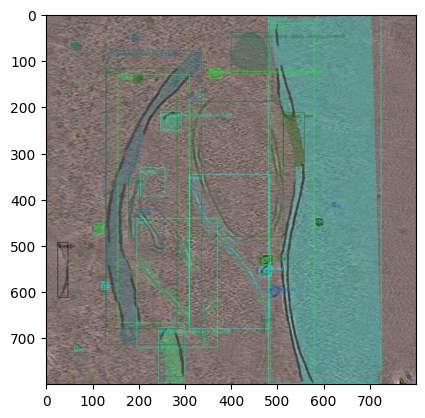

In [7]:
data = dataset[70]
utils.drawannotation(data["pixel_values"], data["labels"]["all"])

In [77]:
data["labels"]["all"]["masks"].shape

torch.Size([134, 800, 800])

In [13]:
path = "/home/feity/cryoem/checkpoints/deformable_all"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [14]:
model = utils.getModel(configs)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 1


In [15]:
ckpt = torch.load(os.path.join(path, "epoch=1427-total_validate_loss=1.55.ckpt"))["state_dict"]
need_del = []
p = [j for j, _ in model.named_parameters()]
for i in ckpt:
    if i not in p or ckpt[i].shape != model.state_dict()[i].shape:
        need_del.append(i)
for i in need_del:
    del ckpt[i]
model.load_state_dict(ckpt, strict=False)

/tmp/ipykernel_69248/1344245907.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, "epoch=1427-total_validate_loss=1.55.ckpt"))["state_

_IncompatibleKeys(missing_keys=['model.all.model.backbone.conv_encoder.model.bn1.weight', 'model.all.model.backbone.conv_encoder.model.bn1.bias', 'model.all.model.backbone.conv_encoder.model.bn1.running_mean', 'model.all.model.backbone.conv_encoder.model.bn1.running_var', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn1.weight', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn1.bias', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn1.running_mean', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn1.running_var', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn2.weight', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn2.bias', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn2.running_mean', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn2.running_var', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn3.weight', 'model.all.model.backbone.conv_encoder.model.layer1.0.bn3.bias', 'model.all.model.backbone.conv_encoder.mo

In [16]:
importlib.reload(utils)
retdict = utils.buildStage2(model, dataset, (800, 800), 0.05, model_names=["all"], has_none=False, single=True)

slice 0
torch.Size([33]) torch.Size([33, 4])
obj_cnts: 33
slice 1
torch.Size([29]) torch.Size([29, 4])
obj_cnts: 62
slice 2
torch.Size([33]) torch.Size([33, 4])
obj_cnts: 95
slice 3
torch.Size([22]) torch.Size([22, 4])
obj_cnts: 117
slice 4
torch.Size([31]) torch.Size([31, 4])
obj_cnts: 148
slice 5
torch.Size([19]) torch.Size([19, 4])
obj_cnts: 167
slice 6
torch.Size([25]) torch.Size([25, 4])
obj_cnts: 192
slice 7
torch.Size([37]) torch.Size([37, 4])
obj_cnts: 229
slice 8
torch.Size([37]) torch.Size([37, 4])
obj_cnts: 266
slice 9
torch.Size([44]) torch.Size([44, 4])
obj_cnts: 310
slice 10
torch.Size([53]) torch.Size([53, 4])
obj_cnts: 363
slice 11
torch.Size([82]) torch.Size([82, 4])
obj_cnts: 445
slice 12
torch.Size([118]) torch.Size([118, 4])
obj_cnts: 563
slice 13
torch.Size([131]) torch.Size([131, 4])
obj_cnts: 694
slice 14
torch.Size([162]) torch.Size([162, 4])
obj_cnts: 856
slice 15
torch.Size([180]) torch.Size([180, 4])
obj_cnts: 1036
slice 16
torch.Size([202]) torch.Size([202, 

In [17]:
importlib.reload(utils)
d = utils.convertStage2Dataset(retdict)
d

Data(x=[6334, 276], edge_index=[2, 90402], y=[6334], box_masks=[6334], boxes=[6334, 4], edge_label=[90402])

In [18]:
torch.save(d, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all.pth")
torch.save(retdict, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all_dict.pkl")

In [2]:
retdict = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all_dict.pkl")
retdict.keys()

/tmp/ipykernel_2724833/146426266.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retdict = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2data

dict_keys(['feature', 'label', 'masks', 'box_mask', 'boxes', 'item_id', 'images', 'sample_mapping'])

In [4]:
import importlib
importlib.reload(utils)
res = utils.get_stage2_model_embeddings("/home/feity/cryoem/checkpoints/stage_2_deformable_all", "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all.pth") 
d = utils.prepareMaskDataset(retdict, res)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 2


/home/feity/cryoem/utils.py:790: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, checkpoint))["state_dict"]
/home/feity/cryoem/utils.py:67

In [5]:
torch.save(d, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_mask.pth")

In [68]:
res["embeddings"].shape

torch.Size([6124, 272])

In [77]:
masks = retdict["masks"]
images = retdict["images"]
images = torch.stack(images, dim=0)
embeds = res["embeddings"][retdict["box_mask"]]
sapple_mapping = retdict["sample_mapping"] 
torch.save({"embed":embeds, "pixel_values":images, "masks":masks, "sample_mapping":sapple_mapping}, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_mask.pth")


In [78]:
{"embed":embeds, "pixel_values":images, "masks":masks, "sample_mapping":sapple_mapping}

{'embed': tensor([[-2.2545, -0.0962,  2.4081,  ...,  0.5976,  5.9099, -0.1798],
         [-1.9837, -0.3888,  2.1050,  ...,  0.2650,  5.5551,  0.2404],
         [-2.3400, -0.1125,  2.2891,  ...,  0.1811,  5.5975,  0.2756],
         ...,
         [-2.2424, -2.3404,  3.6576,  ...,  1.5493,  2.8110,  0.2715],
         [-2.5735, -1.8791,  4.1548,  ...,  1.3598,  3.5173,  0.5186],
         [-2.6268, -2.1899,  5.4663,  ...,  2.7043,  4.1842, -0.3916]]),
 'pixel_values': tensor([[[[0.4591, 0.5027, 0.5903,  ..., 0.0000, 0.0000, 0.0000],
           [0.4859, 0.5037, 0.5378,  ..., 0.0000, 0.0000, 0.0000],
           [0.5875, 0.5171, 0.4590,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.6332, 0.7162, 0.6776,  ..., 0.0000, 0.0000, 0.0000],
           [0.5970, 0.6315, 0.6131,  ..., 0.0000, 0.0000, 0.0000],
           [0.5596, 0.4961, 0.4912,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.4591, 0.5027, 0.5903,  ..., 0.0000, 0.0000, 0.0000],
           [0.4859, 0.5037, 0.5378,  ..., 0.0

In [76]:
retdict["sample_mapping"]

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 2,
 83: 2,
 84: 2,
 85: 2,
 86: 2,
 87: 2,
 88: 2,
 89: 2,
 90: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 2,
 96: 2,
 97: 2,
 98: 2,
 99: 2,
 100: 2,
 101: 2,
 102: 2,
 103: 2,
 104: 2,
 105: 2,
 106: 2,
 107: 2,
 108: 2,
 109: 2,
 110: 2,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 3,
 116: 3,
 117: 3,
 118: 3,
 119: 3,
 120: 3,
 121: 3,
 122: 3,
 12

In [70]:
retdict.keys()

dict_keys(['feature', 'label', 'masks', 'box_mask', 'boxes', 'item_id', 'images', 'sample_mapping'])

In [64]:
d

Data(x=[6124, 276], edge_index=[2, 68120], y=[6124], box_masks=[6124], boxes=[6124, 4], edge_label=[68120])

In [55]:
torch.save(d, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all.pth")

In [ ]:

from transformers.models.deformable_detr.modeling_deformable_detr import DeformableDetrHungarianMatcher 
matcher = DeformableDetrHungarianMatcher(1.0, 5.0, 2.0) 
matcher

def processSingle(model, label, data, target_size, model_names, thres, has_none, single=True):
    ret = [] 
    boxeses = []
    box_masks = []
    l = []
    item_ids = []
    output = model(pixel_values=data["pixel_values"].unsqueeze(0).float(), pixel_mask=data["pixel_mask"].unsqueeze(0).float())
    for idx, i in enumerate(model_names):
        print(i)
        _output = output[i]
        logits = _output["logits"].squeeze(0)
        pred_boxes = _output["pred_boxes"].squeeze(0)
        if has_none:
            print(logits, logits.shape)
            prob = torch.softmax(logits, -1) 
            prob = prob[:, :-1]
        else:
            prob = torch.sigmoid(logits)
        v, pos = torch.max(prob, dim=1)
            
        if i in label and len(label[i]["class_labels"]) > 0:
            o = {}
            o["pred_boxes"] = pred_boxes.unsqueeze(0)
            o["logits"] = logits.unsqueeze(0)
            match_res = matcher(o, [label[i]])
            match_res = match_res[0]
            reserve = v>thres 
            r = torch.zeros_like(reserve, dtype=torch.bool)
            r[match_res[0]] = True
            reserve = reserve | r 
        else:
            reserve = v>thres
        
        v, pos = torch.max(prob, dim=1) 
        logits = logits[reserve] 
        pred_boxes = pred_boxes[reserve] 
        embed = _output["last_hidden_state"].squeeze(0)
        embed = embed[reserve]
        if single:
            model_idx = torch.zeros((pred_boxes.shape[0], 1))
            model_idx[:, 0] = idx 
        else:
            model_idx = torch.zeros((pred_boxes.shape[0], len(model_names)))
            model_idx[:, idx] = 1.0 
            
        pos = torch.zeros((pred_boxes.shape[0], 5))
        pos[:, 0] = label["pos"]
        if "zposmax" in label:
            pos[:, 0] /= label["zposmax"] 
        else:
            pos[:, 0] /= 500 
        print(pred_boxes)
        pos[:, 1] = pred_boxes[:, 0] * (label["size"][0]/target_size[0]) 
        pos[:, 2] = pred_boxes[:, 1] * (label["size"][1]/target_size[1])
        pos[:, 3] = pred_boxes[:, 2] * (label["size"][0]/target_size[0])
        pos[:, 4] = pred_boxes[:, 3] * (label["size"][1]/target_size[1])
        input = torch.concat([model_idx, pos, logits, embed], dim=1)
        ret.append(input)
        if i in label:
            targets = torch.zeros((pred_boxes.shape[0]), dtype=torch.long)
            box_mask = torch.zeros((pred_boxes.shape[0]), dtype=torch.bool) 
            boxes = torch.zeros((pred_boxes.shape[0], 4)) 
            item_id = ["" for i in range(pred_boxes.shape[0])]
            if len(label[i]["class_labels"]) > 0:
                o = {}
                o["pred_boxes"] = pred_boxes.unsqueeze(0)
                o["logits"] = logits.unsqueeze(0)
                # print(o, label[i])
                match_res = matcher(o, [label[i]]) 
                match_res = match_res[0]
                target = label[i]["class_labels"] 
                target = target[match_res[1]]
                # print(targets, target)
                target_boxes = label[i]["boxes"]
                target_boxes = target_boxes[match_res[1]]
                
                for s, t in zip(match_res[0], match_res[1]):
                    item_id[s] = label[i]["item_id"][t]
                
                boxes[match_res[0]] = target_boxes
                box_mask[match_res[0]] = True
                print(box_mask.shape, boxes.shape)
                targets[match_res[0]] = target 
            l.append(targets)
            box_masks.append(box_mask)
            boxeses.append(boxes)
            item_ids.append(item_id)
        else:
            print("meet none")
            l.append(None)
            box_masks.append(None)
            boxeses.append(None)
            item_ids.append(None)
    return {"feature":ret, "label":l, "box_mask":box_masks, "boxes":boxeses, "item_id":item_ids}
    return ret, l, box_masks, boxeses
          
def buildStage2(model, dataset, target_size, thres, model_names=["other", "ribo"], has_none=False, single=True):
    ret = [] 
    l = [] 
    box_masks = []
    boxes = []
    item_ids = []
    images = [] 
    sample_mapping = {}
    ret_dict = {"feature":ret, "label":l, "box_mask":box_masks, "boxes":boxes, "item_id":item_ids, "images":images, "sample_mapping":sample_mapping}
    cnts = 0
    for i in range(len(dataset)):
        print(i)
        data = dataset[i]
        label = data["labels"]
        _ret_dict = processSingle(model, label, data, target_size, model_names, thres, has_none, single)
        for j in _ret_dict:
            ret_dict[j].extend(_ret_dict[j]) 
        ret_dict["images"].append(data["pixel_values"])
        print(_ret_dict["item_id"])
        for i in _ret_dict["item_id"]:
            for j in range(len(i)):
                sample_mapping[cnts] = len(ret_dict["images"]) - 1
                cnts += 1
        
        print(cnts)
    return ret_dict
    # return ret, l, box_masks, boxes
    # return ret, l

In [ ]:
X = torch.cat(retdict["feature"], dim=0)
y = torch.cat(retdict["label"], dim=0)
box_masks = torch.cat(retdict["box_mask"], dim=0)
boxes = torch.cat(retdict["boxes"], dim=0)
item_ids = []
for i in retdict["item_id"]:
    item_ids.extend(i)
X.shape
np.unique(item_ids), len(np.unique(item_ids))

(array(['', 'TS_031_11_1', 'TS_031_11_2', 'TS_031_11_3', 'TS_031_12_1',
        'TS_031_12_2', 'TS_031_12_3', 'TS_031_12_4', 'TS_031_12_5',
        'TS_031_12_6', 'TS_031_12_7', 'TS_031_13_1', 'TS_031_1_1',
        'TS_031_1_10', 'TS_031_1_11', 'TS_031_1_12', 'TS_031_1_13',
        'TS_031_1_14', 'TS_031_1_15', 'TS_031_1_16', 'TS_031_1_17',
        'TS_031_1_18', 'TS_031_1_2', 'TS_031_1_3', 'TS_031_1_4',
        'TS_031_1_5', 'TS_031_1_6', 'TS_031_1_7', 'TS_031_1_8',
        'TS_031_1_9', 'TS_031_2_1', 'TS_031_3_1', 'TS_031_3_10',
        'TS_031_3_100', 'TS_031_3_101', 'TS_031_3_102', 'TS_031_3_103',
        'TS_031_3_104', 'TS_031_3_105', 'TS_031_3_106', 'TS_031_3_107',
        'TS_031_3_108', 'TS_031_3_109', 'TS_031_3_11', 'TS_031_3_110',
        'TS_031_3_111', 'TS_031_3_112', 'TS_031_3_113', 'TS_031_3_114',
        'TS_031_3_115', 'TS_031_3_116', 'TS_031_3_117', 'TS_031_3_118',
        'TS_031_3_119', 'TS_031_3_12', 'TS_031_3_120', 'TS_031_3_121',
        'TS_031_3_122', 'TS_031_3

In [22]:
retdict["item_id"][2]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'TS_031_1_1',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'TS_031_1_15',
 '',
 '',
 '',
 '',
 'TS_031_1_13',
 '']

In [18]:
retdict["item_id"]

[['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_1',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_13',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_15',
  '',
  '',
  ''],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_13',
  '',
  '',
  '',
  '',
  'TS_031_1_1',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_15',
  ''],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_1',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_15',
  '',
  '',
  '',
  '',
  'TS_031_1_13',
  ''],
 ['',
  '',
  '',
  'TS_031_1_1',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'TS_031_1_15',
  '',
  '',
  '',
  '',
  'TS_031_1_13',
  ''],
 ['',
  '',
  '',
  '',
  '',
  ''

In [176]:
with open("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_cdetr.pkl", "wb") as f:
    pickle.dump(retdict, f)

In [ ]:
X = torch.cat(retdict["feature"], dim=0)
y = torch.cat(retdict["label"], dim=0)
box_masks = torch.cat(retdict["box_mask"], dim=0)
boxes = torch.cat(retdict["boxes"], dim=0)
item_ids = []
for i in retdict["item_id"]:
    item_ids.extend(i)
X.shape

torch.Size([8859, 277])

In [191]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def get_neighbors(X, z=500.0, x=500.0, y=500.0, radius=20):
    t = X[:, 1:4]
    t = t.numpy().copy()
    t[:, 0] *= z
    t[:, 1] *= x
    t[:, 2] *= y 
    radius_neighbors = NearestNeighbors(radius=radius)
    radius_neighbors.fit(t)
    neighbors = radius_neighbors.radius_neighbors(t, return_distance=False)
    return neighbors
neighbors = get_neighbors(X)


In [67]:
X[:, 1:4]

tensor([[0.0000, 0.5260, 0.3749],
        [0.0000, 0.4722, 0.3904],
        [0.0000, 0.4975, 0.4162],
        ...,
        [0.8000, 0.6449, 0.6262],
        [0.8000, 0.4516, 0.6181],
        [0.8000, 0.6059, 0.6775]])

In [193]:
source = [] 
dest = [] 
edge_label = []
for i, j in enumerate(neighbors):
    for k in j:
        source.append(i)
        dest.append(k)
        if item_ids[i] == item_ids[k] and item_ids[i] != "":
            edge_label.append(1)
        else:
            edge_label.append(0) 
edges = torch.tensor([source, dest], dtype=torch.long)
edges

tensor([[   0,    0,    0,  ..., 8858, 8858, 8858],
        [  20,    6,    0,  ..., 8720, 8819, 8807]])

In [194]:

from torch_geometric.data import Data 
t = Data(x=X, edge_index=edges, y=y)
t.box_masks = box_masks
t.boxes = boxes
t.edge_label = torch.tensor(edge_label, dtype=torch.long)
# t.train_mask
torch.save(t, "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr.pth")

In [195]:
t

Data(x=[8859, 277], edge_index=[2, 909643], y=[8859], box_masks=[8859], boxes=[8859, 4], edge_label=[909643])

In [ ]:
THRES=0.1
datas = []
for i in range(len(dataset)):
    data = dataset[i]
    size = data["labels"]["size"]
    output = model(pixel_values=data["pixel_values"].unsqueeze(0).float(), pixel_mask=data["pixel_mask"].unsqueeze(0).float())
    for j in ["ribo", "other"]:
        results = utils.postSegmentationTreatment(output[j], 0.00, target_sizes, mask_threshold=None)
        result = results[0]
        datas.append({"pixel_values":data["pixel_values"], "labels":data["labels"], "result":result})

tensor([-6.2589, -0.8516, -6.3564, -1.9572, -6.2141, -6.2538, -6.1188, -6.2807,
        -6.2625, -6.3060, -6.3387, -6.2274, -6.3543, -6.2882],
       grad_fn=<SelectBackward0>)

In [17]:
data["labels"]["other"]

{'bboxes': BoundingBoxes([[538, 410, 563, 520],
                [ 16, 171, 345, 383],
                [138,  42, 294, 323],
                [315, 236, 484, 358],
                [ 79, 193, 182, 305],
                [395,  97, 499, 217],
                [ 49,  11, 160, 169],
                [  3,  99,  21, 180],
                [  0, 313, 129, 348],
                [503,  65, 568, 187],
                [ 39, 214,  61, 286],
                [215,   5, 341, 103],
                [551, 420, 565, 459],
                [ 56, 230, 113, 290],
                [213, 398, 214, 401],
                [  0, 522, 119, 613],
                [  0,   0, 351, 387],
                [ 87,  15, 166, 100],
                [393,  61, 568, 218],
                [ 47, 116,  97, 166],
                [316, 237, 482, 358],
                [225, 392, 325, 466],
                [475,  55, 491,  96],
                [113,  86, 146, 109],
                [494, 140, 503, 170],
                [464, 168, 480, 185],
  

(array([13., 72., 28., 16., 13., 27., 35., 45., 46.,  5.]),
 array([-4.07932568, -3.57321596, -3.06710625, -2.56099653, -2.05488706,
        -1.54877734, -1.04266763, -0.53655791, -0.03044825,  0.47566143,
         0.98177111]),
 <BarContainer object of 10 artists>)

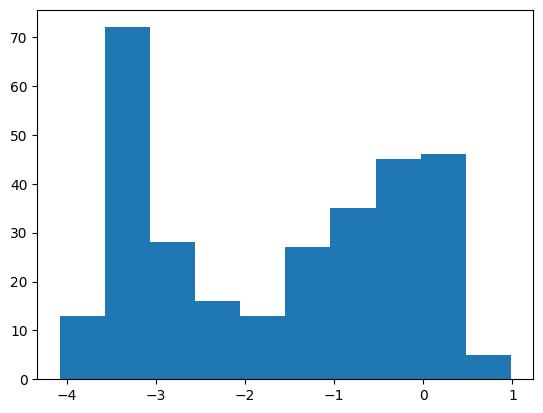

In [47]:
t = output["ribo"].logits.detach().cpu().numpy()
plt.hist(t[0, :, 3])

In [25]:
matcher_res = matcher(o, [data["labels"]["ribo"]])
matcher_res

[(tensor([  6,  18,  25,  30,  38,  39,  44,  45,  49,  53,  59,  61,  62,  64,
           69,  79,  80,  85,  96,  97,  98, 106, 107, 108, 117, 124, 129, 132,
          136, 139, 141, 144, 146, 147, 148, 149, 152, 153, 159, 163, 164, 167,
          170, 171, 172, 173, 174, 175, 177, 178, 179, 181, 185, 186, 188, 190,
          191, 197, 201, 203, 207, 209, 211, 224, 226, 228, 229, 231, 241, 244,
          249, 253, 259, 262, 263, 266, 268, 269, 270, 271, 276, 277, 280, 289,
          290, 291, 292, 297, 298]),
  tensor([39,  4, 25, 12, 34, 45, 32,  5, 78, 69, 63,  6, 54, 37, 62, 28, 79, 42,
          27, 21, 30, 57, 36, 75, 66, 15, 58, 22,  8, 33, 10, 59, 83, 38, 73, 76,
           0, 82, 68,  9, 72, 81, 65, 40, 18, 23, 48, 44, 52,  7, 17, 26, 11, 64,
          60, 86, 35, 50, 71, 80, 70, 85, 41,  2, 49,  3, 16, 29, 43, 13, 56, 87,
          61, 55, 46, 24, 14, 31, 84, 77, 20, 19, 88, 53, 74, 67, 47, 51,  1]))]

In [2]:
import modules 
import torch.nn as nn
import torchmetrics
class testModule(nn.Module):
    def __init__(self, additional_input_dim=20,
        additional_output_dim=16,output_dim=15, feature_dim=256):
        self.additional_output_dim = additional_output_dim
        self.additional_input_dim = additional_input_dim
        super(testModule, self).__init__()
        self.additional_input_layer = modules.AdditionalInputLayer(
            additional_input_dim, additional_output_dim
        )
        self.gnn = modules.GCN(feature_dim + additional_output_dim, output_dim, layer_type="AGNNConv")
        
    def forward(self, x, edge_index):
        additional_input, model_feature = (
                x[:, : self.additional_input_dim],
                x[:, self.additional_input_dim :],
            )
        additional_feature = self.additional_input_layer(additional_input)
        inputs = torch.cat([model_feature, additional_feature], dim=1)
        return self.gnn(inputs, edge_index)
model = testModule()
acc = torchmetrics.Accuracy("multiclass", num_classes=15).to(0)


/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
a.x 

tensor([[ 0.0000,  0.2600,  0.0563,  ...,  0.7164, -0.9363, -0.7746],
        [ 0.0000,  0.2600,  0.0775,  ...,  0.2747,  0.6724, -0.6657],
        [ 0.0000,  0.2600,  0.2885,  ..., -0.1856,  0.3923,  0.3909],
        ...,
        [ 1.0000,  0.2600,  0.1232,  ...,  0.7206,  0.5438,  2.1159],
        [ 1.0000,  0.2600,  0.1748,  ...,  1.2374,  0.4607,  1.1928],
        [ 1.0000,  0.2600,  0.2947,  ...,  0.8951,  0.4562,  3.3003]])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithAdditionalInput(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, additional_input_dim=10):
        super(UNetWithAdditionalInput, self).__init__()

        # Contracting path (Encoder)
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Process additional input
        self.additional_fc = nn.Sequential(
            nn.Linear(additional_input_dim, 1024),  # Map additional input to the same dimension as bottleneck
            nn.ReLU(inplace=True)
        )

        # Expanding path (Decoder)
        self.upconv4 = self.upconv(2048, 512)  # Bottleneck + Additional input (1024 + 1024 = 2048)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """Double convolution layers with ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        """Upsample the feature map using transpose convolution."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, upsampled, bypass):
        """Crop the bypass connection to match the size of the upsampled feature map."""
        _, _, h, w = upsampled.size()
        bypass = F.interpolate(bypass, size=(h, w), mode="bilinear", align_corners=True)
        return torch.cat((upsampled, bypass), dim=1)

    def forward(self, x, additional_input):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Process additional input
        additional_input_processed = self.additional_fc(additional_input)
        additional_input_processed = additional_input_processed.unsqueeze(-1).unsqueeze(-1)  # Reshape to (batch, 1024, 1, 1)
        additional_input_processed = additional_input_processed.expand(-1, -1, bottleneck.size(2), bottleneck.size(3))  # Match spatial dims

        # Concatenate bottleneck and additional input
        bottleneck = torch.cat((bottleneck, additional_input_processed), dim=1)

        # Decoder
        up4 = self.upconv4(bottleneck)
        concat4 = self.crop_and_concat(up4, enc4)
        dec4 = self.dec4(concat4)

        up3 = self.upconv3(dec4)
        concat3 = self.crop_and_concat(up3, enc3)
        dec3 = self.dec3(concat3)

        up2 = self.upconv2(dec3)
        concat2 = self.crop_and_concat(up2, enc2)
        dec2 = self.dec2(concat2)

        up1 = self.upconv1(dec2)
        concat1 = self.crop_and_concat(up1, enc1)
        dec1 = self.dec1(concat1)

        # Output layer
        output = self.out_conv(dec1)
        output = output.squeeze(1)  # Remove channel dimension
        output = torch.sigmoid(output)  # Sigmoid activation for binary classification
        return output


# Test the modified U-Net model
if __name__ == "__main__":
    # Create the U-Net model with additional input
    model = UNetWithAdditionalInput(in_channels=3, out_channels=3, additional_input_dim=10)

    # Create a random input tensor with size (batch_size=1, channels=3, height=800, width=800)
    input_tensor = torch.randn(1, 3, 800, 800)

    # Create a random additional input tensor with size (batch_size=1, additional_input_dim=10)
    additional_input = torch.randn(1, 10)

    # Perform a forward pass
    output = model(input_tensor, additional_input)

    # Check the output size
    print("Input shape: ", input_tensor.shape)
    print("Additional input shape: ", additional_input.shape)
    print("Output shape:", output.shape)


Input shape:  torch.Size([1, 3, 800, 800])
Additional input shape:  torch.Size([1, 10])
Output shape: torch.Size([1, 3, 800, 800])


In [ ]:
model = UNetWithAdditionalInput(in_channels=3, out_channels=1, additional_input_dim=10)

In [3]:
graph = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all.pth") 
retdict = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_mask.pth")
model = utils.loadModel("checkpoints/stage_2_mask", "epoch=128-total_validate_loss=0.0059.ckpt")

/tmp/ipykernel_3818128/2974850740.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2datas

NameError: name 'utils' is not defined

In [120]:
retdict["masks"][2].sum()

tensor(143)

In [9]:
model.stage = "stage 2"
res = model(graph.x, graph.edge_index)
res.keys()

dict_keys(['predict', 'box', 'edge', 'embeddings'])

In [10]:
need = []
for i in retdict["sample_mapping"]:
    if retdict["sample_mapping"][i] == 20:
        need.append(i)

In [11]:
class E(object):
    pass
r = E()
r.a = 1

In [12]:
r.logits = res["predict"][need]
r.pred_boxes = res["box"][need]
r.embeddings = res["embeddings"][need]

In [13]:
r.logits = r.logits.unsqueeze(0)
r.pred_boxes = r.pred_boxes.unsqueeze(0)

In [15]:
r.embeddings.shape

torch.Size([259, 272])

In [101]:
import importlib
importlib.reload(utils)
masks = utils.generateMasks(model, r.embeddings, retdict["pixel_values"][20], device=0)

100%|██████████| 52/52 [00:06<00:00,  8.59it/s]


In [117]:
r.embeddings

tensor([[-0.6401, -0.0068,  0.2452,  ..., -0.4006, -1.1266, -1.3623],
        [-0.5695,  0.6561,  0.3771,  ..., -0.3433, -2.0946, -1.2021],
        [-0.7578, -0.8401, -1.9406,  ..., -1.5263, -1.1621, -2.1737],
        ...,
        [-1.0571, -0.7629, -0.4680,  ..., -1.0385, -0.6073, -2.4615],
        [-1.2718, -0.1501,  0.8867,  ..., -0.7570, -1.2462, -2.1620],
        [-1.0173, -2.0682, -3.0544,  ..., -5.8353, -1.2383, -2.1795]],
       grad_fn=<IndexBackward0>)

In [102]:
r.pred_masks = masks.unsqueeze(0)

In [116]:
masks[18]

tensor([[0.1012, 0.0381, 0.0291,  ..., 0.0092, 0.0168, 0.0744],
        [0.0352, 0.0070, 0.0046,  ..., 0.0006, 0.0015, 0.0190],
        [0.0259, 0.0044, 0.0028,  ..., 0.0002, 0.0006, 0.0112],
        ...,
        [0.0280, 0.0050, 0.0034,  ..., 0.0002, 0.0006, 0.0112],
        [0.0392, 0.0085, 0.0060,  ..., 0.0006, 0.0015, 0.0190],
        [0.1099, 0.0447, 0.0360,  ..., 0.0093, 0.0169, 0.0749]])

In [103]:
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(r, 0.65, target_sizes, mask_threshold=0.1, style="None")
result = results[0]

torch.Size([103, 800, 800]) tensor([800., 800.])


In [104]:
keep = utils.bbnms(0.2, result["boxes"], result["scores"], result["labels"])
for i in result:
    result[i] = result[i][keep]

In [105]:
def drawannotation(image, target):
    class_names = [str(i) for i in range(14)]
    int_colors = plt.cm.get_cmap("tab20", len(class_names))
    # import matplotlib.pyplot as plt
    from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

    if isinstance(image, torch.Tensor):
        image = image.numpy()
    if np.max(image) < 10:
        image -= np.min(image)
        image /= np.max(image)
        image = torch.tensor(image * 255).type(torch.uint8)

    if "masks" in target:
        annotated_tensor = draw_segmentation_masks(
            image=image,
            masks=target["masks"],
            alpha=0.1,
            # colors=[int_colors(i) for i in [class_names.index(label) for label in target["names"]]]
        )
    else:
        annotated_tensor = image
        annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
    # Annotate the sample image with labels and bounding boxes
    # if "names" in target:
    annotated_tensor = draw_bounding_boxes(
        image=annotated_tensor,
        boxes=target["bboxes"],
        labels=target["names"] if "names" in target else target["labels"],
        font_size=30,
        colors=[class_names.index(label) for label in target["names"]]
    )
    res = annotated_tensor.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.moveaxis(res, 0, -1))

/tmp/ipykernel_3137088/2387138470.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", len(class_names))


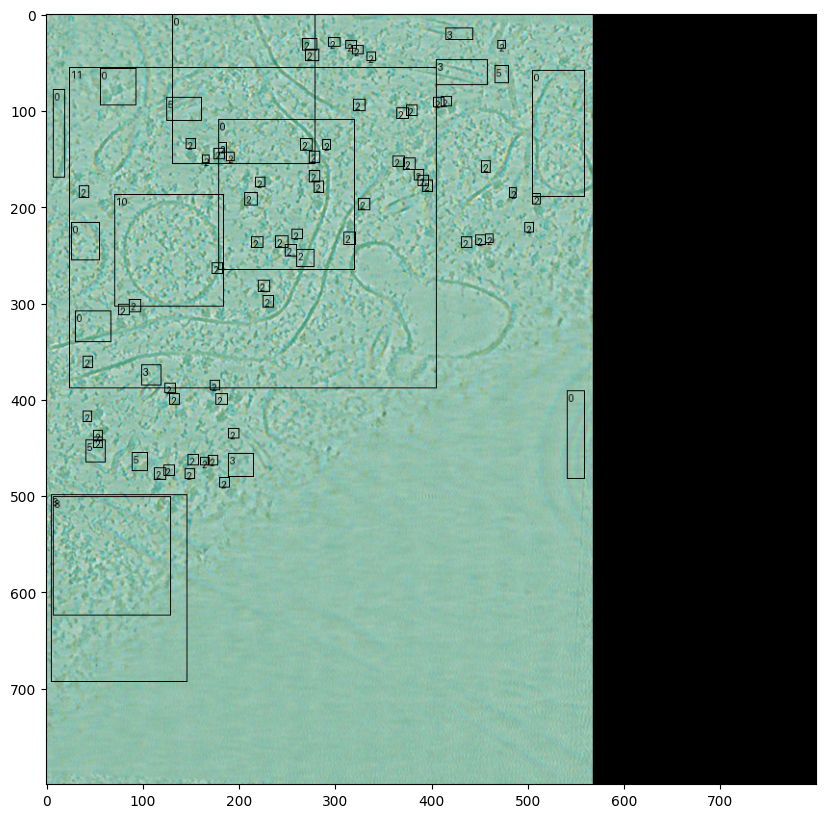

In [107]:
img = retdict["pixel_values"][20]
t = utils.toTarget(result, img.shape[1:])
# t["masks"] = output > 0.5
importlib.reload(utils)
drawannotation(img.cpu().numpy(), t)

In [108]:
t["masks"].shape, t["bboxes"].shape

(torch.Size([85, 800, 800]), torch.Size([85, 4]))

In [112]:
t["masks"].sum()

tensor(170)

In [55]:
t

{'labels': tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  6,  6,  6,  6,  7,  9,
         11, 11, 12, 12, 12]),
 'bboxes': BoundingBoxes([[4.7000e+02, 5.0859e+02, 5.5597e+02, 5.6857e+02],
                [5.4641e+02, 6.0347e+02, 5.9142e+02, 6.3325e+02],
       

In [128]:
result["bboxes"] = result["boxes"].detach().cpu()
result["name"] = ["null" for i in range(result["bboxes"].shape[0])]

In [129]:
utils.drawannotation(retdict["images"][15], result)

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'bytes'>.

In [123]:
results

[{'scores': tensor([0.6142, 0.6498, 0.5942, 0.7828, 0.5801, 0.7532, 0.6673, 0.6189, 0.7608,
          0.9115, 0.9943, 0.9934, 0.7176, 0.8349, 0.9505, 0.9865, 0.5189, 0.9762,
          0.8729, 0.8497, 0.6202, 0.8909, 0.9665, 0.9936, 0.9970, 0.8088, 0.9779,
          0.9204, 0.9955, 0.9967, 0.9948, 0.8977, 0.9434, 0.5977, 0.9980, 0.9812,
          0.5707, 0.9786, 0.9775, 0.9822, 0.5143, 0.9864, 0.7510, 0.6853, 0.9920,
          0.8556, 0.8825, 0.9985, 0.9285, 0.6059, 0.5787, 0.7787, 0.7649, 0.7440,
          0.5463, 0.9877, 0.9865, 0.9462, 0.9943], grad_fn=<IndexBackward0>),
  'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
  'boxes': tensor([[  0.0000, 188.7418,  76.3019, 304.7826],
          [  0.0000, 188.4498,  74.3595, 301.8463],
          [257.6606,  71.5238, 330.9514, 180.2159],
          [ 71.7996,  51.1993, 145.1